Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [ ]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

In [ ]:
def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date')
    
    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype('object')
    
    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL', 'Neighborhood','Reviewer'])
    
    # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])

    # Drop Empty column
    df = df.drop(columns=['Queso'])

    # Fixing Encoded Columns (1,0)
    for col in df: 
      if df[col].nunique() <= 4:
       df[col].replace({"X":"1","x":"1","Yes":"1","No":"0"}, inplace=True)
       df[col] = df[col].fillna('0')
       df[col] = df[col].astype(int)

    # # # BURRITO COLUMN
    # # Fixing Strings
    # df['Burrito'] = df['Burrito'].str.lower().str.replace("\\s","")
    # # Encoding
    # one_hot = pd.get_dummies(df['Burrito'])
    # # Drop column Burrito as it is now encoded
    # df = df.drop('Burrito',axis = 1)
    # # Join the encoded df
    # df = df.join(one_hot)

    Search = ['California', 'Asada', 'Surf', 'Carnitas']
    df[Search] = 0
    df.loc[df['Burrito'].str.contains('California'), 'California'] = 1
    df.loc[df['Burrito'].str.contains('asada'), 'Asada'] = 1
    df.loc[df['Burrito'].str.contains('surf'), 'Surf'] = 1
    df.loc[df['Burrito'].str.contains('Carnitas'), 'Carnitas'] = 1
    df.drop(columns='Burrito', inplace=True)

    return df

filepath = DATA_PATH + 'burritos/burritos.csv'

**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

In [ ]:
filepath = DATA_PATH + 'burritos/burritos.csv'
df = wrangle(filepath)

During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [ ]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

df.head()

,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,California,Asada,Surf,Carnitas
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2016-01-24,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2016-01-24,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2016-01-24,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2016-01-27,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

In [ ]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 60 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Yelp            87 non-null     float64
 1   Google          87 non-null     float64
 2   Chips           421 non-null    int64  
 3   Cost            414 non-null    float64
 4   Hunger          418 non-null    float64
 5   Mass (g)        22 non-null     float64
 6   Density (g/mL)  22 non-null     float64
 7   Length          283 non-null    float64
 8   Circum          281 non-null    float64
 9   Volume          281 non-null    float64
 10  Tortilla        421 non-null    float64
 11  Temp            401 non-null    float64
 12  Meat            407 non-null    float64
 13  Fillings        418 non-null    float64
 14  Meat:filling    412 non-null    float64
 15  Uniformity      419 non-null    float64
 16  Salsa           396 non-null    float64
 17  Synergy         

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [ ]:
X = df.drop(columns='Great')
y = df['Great']

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [ ]:
mask = (df.index >= "2016-01-01") & (df.index < "2018-01-01")

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', round(baseline_acc*100, 2),'%')

Baseline Accuracy Score: 58.27 %


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [ ]:
model_logr = make_pipeline(
    #OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_logr.fit(X_train,y_train);

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [ ]:
training_acc = model_logr.score(X_train, y_train)
test_acc = model_logr.score(X_test,y_test)

print('Training Accuracy:', round(training_acc*100, 2),'%')
print('Test Accuracy:', round(test_acc*100, 2),'%')

Training MAE: 91.34 %
Test MAE: 75.0 %


# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

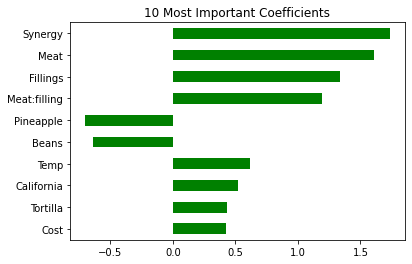

In [ ]:
# Create your horizontal barchart here.

Coefficients = model_logr.named_steps.logisticregression.coef_.flatten()
Features = X_train.columns #model_logr.named_steps.onehotencoder.get_feature_names()

Best_features = pd.Series(data=Coefficients, index=Features).sort_values(key=abs)
Best_features.tail(10).plot(kind='barh', color='green')
plt.title('10 Most Important Coefficients');

There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

In [ ]:
# Write code here to explore the differences between `predict` and `predict_proba`.

model_logr.predict(X_test)

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [ ]:
model_logr.predict_proba(X_test)[:10]

array([[4.63785865e-05, 9.99953621e-01],
       [9.99968710e-01, 3.12899815e-05],
       [3.74843758e-05, 9.99962516e-01],
       [2.47218351e-03, 9.97527816e-01],
       [5.35521960e-01, 4.64478040e-01],
       [1.57196635e-05, 9.99984280e-01],
       [9.98545632e-01, 1.45436762e-03],
       [8.60810365e-01, 1.39189635e-01],
       [3.64548384e-02, 9.63545162e-01],
       [4.10559229e-04, 9.99589441e-01]])

**Give your written answer here:**


* What data type do `predict` and `predict_proba` output?
* What numerical values are in the output?
* What do those numerical values represent?

**predict: A binary list of prediction\
predict_proba: 2 column array with the probabilities for each category (1 or 0)**

* What are the shapes of their different output?\

predict: 1D array\
  predict_proba: 2 column array (2D)





In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp_mean.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# build and fit model
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.0002, patience=1, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
# YOUR CODE HERE
model2 = Sequential()

model2.add(Dense(32, 'relu'))
model2.add(Dense(20, 'relu'))
model2.add(Dense(1, 'sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.fit(X, y, epochs=100, callbacks=[early_stopping_callback])




Epoch 1/100
14/14 [==============================] - 1s 2ms/step - loss: 0.6795 - accuracy: 0.6033
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.6983
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.5314 - accuracy: 0.7553
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.7910
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 0.8195
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.4023 - accuracy: 0.8480
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.3675 - accuracy: 0.8599
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3393 - accuracy: 0.8812
Epoch 9/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.8884
Epoch 10/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2916 - accuracy: 0.8979
Epoch 11/